<a href="https://colab.research.google.com/github/orhansonmeztr/junk/blob/main/qq_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!pip install scann -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 64.3 MB/s eta 0:00:00


In [5]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from numpy.random import seed
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import scann
plt.style.use('ggplot')
# import openai
from sklearn.decomposition import PCA, TruncatedSVD,FactorAnalysis
from sklearn.preprocessing import StandardScaler
from math import log2
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import joblib

In [6]:
query_num = 2000

In [18]:
def apk(actual, predicted, k=10):
    if len(predicted) > k:
        predicted = predicted[:k]
    result = 0.0
    score = 0.0
    num_hits = 0.0
    hits = []
    for i, p in enumerate(predicted):
        if p in actual[:i+1] and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i + 1.0)
        hits.append(num_hits)
    if score != 0.0:
        result = score / num_hits
    return result

def mapk(actual, predicted, k=10):
    return np.mean([apk(a,p,k) for a,p in zip(actual, predicted)])

def intersect(actual, predicted,k):
    return np.intersect1d(actual[:k], predicted[:k])

def hit_rate(actual, predicted,k):
    total = 0
    for i in range(len(actual)):
        intersection = intersect(actual[i], predicted[i],k)
        total = total + len(intersection)
    return total


def mean_reciprocal_rank(idx, k):
    rank = []
    for i in range(len(idx)):
        rank.append(np.where(idx[i][:k] == i)[0])

    elevated_rank = np.add(rank,1)
    elevated_rank = np.concatenate(elevated_rank)
    elevated_rank_len = len(elevated_rank)
    reciprocal_rank = np.divide(1,elevated_rank)
    reciprocal_rank_sum = np.sum(reciprocal_rank)
    # print('asfasfasfas',len(idx))
    # return reciprocal_rank_sum/elevated_rank_len
    return reciprocal_rank_sum/len(idx)    

def dcg_calc(similarity_scores, K):
    similarity_len = len(similarity_scores)
    total_dcg = []
    for similarities in similarity_scores:
        dcg = 0
        for k in range(1,K):
            rel_k = similarities[k-1]
            dcg += rel_k / log2(1 + k)
        total_dcg.append(dcg)
    return np.sum(total_dcg)/similarity_len    


def metrics_calculator(raw_idx, reduced_idx, k_values):
    k = k_values
    ap = []
    hit = []
    mrr = []
    for i in k:
        ap.append( mapk(raw_idx, reduced_idx,i))
        hit.append( hit_rate(raw_idx, reduced_idx,i))
        mrr.append(mean_reciprocal_rank(reduced_idx, i))
    return ap, hit , mrr    

In [32]:
vector_dir = 'drive/MyDrive/bbc_project/data/contentVectors.npy'
title_dir = 'drive/MyDrive/bbc_project/data/titleVectors.npy'
embedding_vectors = np.load(vector_dir)
title_gpt_vectors = np.squeeze(np.load(title_dir))
print((embedding_vectors).shape)
print(title_gpt_vectors.shape)

(15468, 1536)
(15468, 1536)


In [36]:
def pca_reducer(target_dimension, content, title):
    pca_name = '_pca_'+str(target_dimension)
    pca_ = PCA(n_components=target_dimension, random_state = 42, svd_solver = 'arpack')
    pca_.fit(content)
    content_vectors_pca = pca_.transform(content)
    title_vectors_pca = pca_.transform(title)

    inverse_content = pca_.inverse_transform(content_vectors_pca)
    inverse_title = pca_.inverse_transform(title_vectors_pca)

    np.save('./content_vectors'+pca_name,content_vectors_pca)
    np.save('./title_vectors'+pca_name,title_vectors_pca)
    np.save('./inverse_content_vectors'+pca_name, inverse_content)
    np.save('./inverse_title_vectors'+pca_name, inverse_title)
    joblib.dump(pca_, pca_name)

def svd_reducer(target_dimension, content, title):
    svd_name = '_svd_'+str(target_dimension)
    svd_ = TruncatedSVD(n_iter= 25, n_components = target_dimension, random_state = 42 )
    svd_.fit(content)
    content_vectors_svd = svd_.transform(content)
    title_vectors_svd = svd_.transform(title)

    inverse_content = svd_.inverse_transform(content_vectors_svd)
    inverse_title = svd_.inverse_transform(title_vectors_svd)

    np.save('./content_vectors'+svd_name,content_vectors_svd)
    np.save('./title_vectors'+svd_name,title_vectors_svd)
    np.save('./inverse_content_vectors'+svd_name, inverse_content)
    np.save('./inverse_title_vectors'+svd_name, inverse_title)
    joblib.dump(svd_, svd_name)

    

In [37]:
pca_reducer(256, embedding_vectors, title_gpt_vectors)
svd_reducer(256, embedding_vectors, title_gpt_vectors)

pca_reducer(593, embedding_vectors, title_gpt_vectors)
svd_reducer(593, embedding_vectors, title_gpt_vectors)

pca_reducer(1007, embedding_vectors, title_gpt_vectors)
svd_reducer(1007, embedding_vectors, title_gpt_vectors)

In [ ]:
# pca_256 = PCA(n_components=256, random_state = 42, svd_solver = 'arpack')
# embedding_vectors_pca = pca_256.fit_transform(embedding_vectors)
# title_vectors_pca = pca_256.transform(title_gpt_vectors)

# svd_256 = TruncatedSVD(n_iter= 25, n_components = 256 ).fit(embedding_vectors)
# embedding_vectors_svd = svd_256.fit_transform(embedding_vectors)
# title_vectors_svd = svd_256.transform(title_gpt_vectors)

# fa_256 = FactorAnalysis(max_iter= 60, n_components = 256 , iterated_power= 5  ).fit(embedding_vectors)
# fa_256_reduced_content = fa_256.transform(embedding_vectors)
# fa_256_reduced_title = fa_256.transform(title_gpt_vectors)

In [38]:
content_pca_256 = np.load('./content_vectors_pca_256.npy')
content_svd_256 = np.load('./content_vectors_svd_256.npy')

title_pca_256 = np.load('./title_vectors_pca_256.npy')
title_svd_256 = np.load('./title_vectors_svd_256.npy')

content_pca_256_inverse = np.load('./inverse_content_vectors_pca_256.npy')
content_svd_256_inverse = np.load('./inverse_content_vectors_svd_256.npy')

title_pca_256_inverse = np.load('./inverse_title_vectors_pca_256.npy')
title_svd_256_inverse = np.load('./inverse_title_vectors_svd_256.npy')
### -------
content_pca_593 = np.load('./content_vectors_pca_593.npy')
content_svd_593 = np.load('./content_vectors_svd_593.npy')

title_pca_593 = np.load('./title_vectors_pca_593.npy')
title_svd_593 = np.load('./title_vectors_svd_593.npy')

content_pca_593_inverse = np.load('./inverse_content_vectors_pca_593.npy')
content_svd_593_inverse = np.load('./inverse_content_vectors_svd_593.npy')

title_pca_593_inverse = np.load('./inverse_title_vectors_pca_593.npy')
title_svd_593_inverse = np.load('./inverse_title_vectors_svd_593.npy')
### -------
content_pca_1007 = np.load('./content_vectors_pca_1007.npy')
content_svd_1007 = np.load('./content_vectors_svd_1007.npy')

title_pca_1007 = np.load('./title_vectors_pca_1007.npy')
title_svd_1007 = np.load('./title_vectors_svd_1007.npy')

content_pca_1007_inverse = np.load('./inverse_content_vectors_pca_1007.npy')
content_svd_1007_inverse = np.load('./inverse_content_vectors_svd_1007.npy')

title_pca_1007_inverse = np.load('./inverse_title_vectors_pca_1007.npy')
title_svd_1007_inverse = np.load('./inverse_title_vectors_svd_1007.npy')

In [39]:
print('content_pca_256 shape:',np.array(content_pca_256).shape)
print('content_svd_256 shape:',np.array(content_svd_256).shape)
print('title_pca_256 shape:',np.array(title_pca_256).shape)
print('title_svd_256 shape:',np.array(title_svd_256).shape)
print('content_pca_256_inverse shape:',np.array(content_pca_256_inverse).shape)
print('content_svd_256_inverse shape:',np.array(content_svd_256_inverse).shape)
print('title_pca_256_inverse shape:',np.array(title_pca_256_inverse).shape)
print('title_svd_256_inverse shape:',np.array(title_svd_256_inverse).shape)

print('content_pca_593 shape:',np.array(content_pca_593).shape)
print('content_svd_593 shape:',np.array(content_svd_593).shape)
print('title_pca_593 shape:',np.array(title_pca_593).shape)
print('title_svd_593 shape:',np.array(title_svd_593).shape)
print('content_pca_593_inverse shape:',np.array(content_pca_593_inverse).shape)
print('content_svd_593_inverse shape:',np.array(content_svd_593_inverse).shape)
print('title_pca_593_inverse shape:',np.array(title_pca_593_inverse).shape)
print('title_svd_593_inverse shape:',np.array(title_svd_593_inverse).shape)

print('content_pca_1007 shape:',np.array(content_pca_1007).shape)
print('content_svd_1007 shape:',np.array(content_svd_1007).shape)
print('title_pca_1007 shape:',np.array(title_pca_1007).shape)
print('title_svd_1007 shape:',np.array(title_svd_1007).shape)
print('content_pca_1007_inverse shape:',np.array(content_pca_1007_inverse).shape)
print('content_svd_1007_inverse shape:',np.array(content_svd_1007_inverse).shape)
print('title_pca_1007_inverse shape:',np.array(title_pca_1007_inverse).shape)
print('title_svd_1007_inverse shape:',np.array(title_svd_1007_inverse).shape)

content_pca_256 shape: (15468, 256)
content_svd_256 shape: (15468, 256)
title_pca_256 shape: (15468, 256)
title_svd_256 shape: (15468, 256)
content_pca_256_inverse shape: (15468, 1536)
content_svd_256_inverse shape: (15468, 1536)
title_pca_256_inverse shape: (15468, 1536)
title_svd_256_inverse shape: (15468, 1536)
content_pca_593 shape: (15468, 593)
content_svd_593 shape: (15468, 593)
title_pca_593 shape: (15468, 593)
title_svd_593 shape: (15468, 593)
content_pca_593_inverse shape: (15468, 1536)
content_svd_593_inverse shape: (15468, 1536)
title_pca_593_inverse shape: (15468, 1536)
title_svd_593_inverse shape: (15468, 1536)
content_pca_1007 shape: (15468, 1007)
content_svd_1007 shape: (15468, 1007)
title_pca_1007 shape: (15468, 1007)
title_svd_1007 shape: (15468, 1007)
content_pca_1007_inverse shape: (15468, 1536)
content_svd_1007_inverse shape: (15468, 1536)
title_pca_1007_inverse shape: (15468, 1536)
title_svd_1007_inverse shape: (15468, 1536)


In [42]:
len()

593

In [43]:
np.linalg.norm(content_pca_593[0])

0.5473829827335618

## DIM 256

In [40]:
fa_256 = FactorAnalysis(max_iter= 25, n_components = 256 ).fit(embedding_vectors)
fa_256_reduced_content = fa_256.transform(embedding_vectors)
fa_256_reduced_title = fa_256.transform(title_gpt_vectors)

np.save('./fa_256_reduced_content.npy',fa_256_reduced_content)
np.save('./fa_256_reduced_title.npy',fa_256_reduced_title)

In [44]:
searcher_raw = scann.scann_ops_pybind.builder(embedding_vectors, 50, "dot_product").tree(
    num_leaves=1500, num_leaves_to_search=100, training_sample_size=250000).score_ah(
    2, anisotropic_quantization_threshold=0.2).reorder(100).build()

searcher_pca = scann.scann_ops_pybind.builder(content_pca_256, 50, "dot_product").tree(
    num_leaves=1500, num_leaves_to_search=100, training_sample_size=250000).score_ah(
    2, anisotropic_quantization_threshold=0.2).reorder(100).build()

searcher_svd = scann.scann_ops_pybind.builder(content_svd_256, 50, "dot_product").tree(
    num_leaves=1500, num_leaves_to_search=100, training_sample_size=250000).score_ah(
    2, anisotropic_quantization_threshold=0.2).reorder(100).build() 

searcher_pca_256_inverse = scann.scann_ops_pybind.builder(content_pca_256_inverse, 50, "dot_product").tree(
    num_leaves=1500, num_leaves_to_search=100, training_sample_size=250000).score_ah(
    2, anisotropic_quantization_threshold=0.2).reorder(100).build() 

searcher_svd_256_inverse = scann.scann_ops_pybind.builder(content_svd_256_inverse, 50, "dot_product").tree(
    num_leaves=1500, num_leaves_to_search=100, training_sample_size=250000).score_ah(
    2, anisotropic_quantization_threshold=0.2).reorder(100).build()     

searcher_fa_256 = scann.scann_ops_pybind.builder(fa_256_reduced_content, 50, "dot_product").tree(
    num_leaves=1500, num_leaves_to_search=100, training_sample_size=250000).score_ah(
    2, anisotropic_quantization_threshold=0.2).reorder(100).build()    

In [45]:
raw_idx = []
reduced_idx_pca = []
reduced_idx_svd = []
inverse_idx_pca = []
inverse_idx_svd = []
reduced_idx_fa = []
for i in range(query_num):
    raw_idx.append(searcher_raw.search(title_gpt_vectors[i])[0])
    reduced_idx_pca.append(searcher_pca.search(title_pca_256[i])[0])
    reduced_idx_svd.append(searcher_svd.search(title_svd_256[i])[0])
    inverse_idx_pca.append(searcher_pca_256_inverse.search(title_pca_256_inverse[i])[0])
    inverse_idx_svd.append(searcher_svd_256_inverse.search(title_svd_256_inverse[i])[0])
    reduced_idx_fa.append(searcher_fa_256.search(fa_256_reduced_title[i])[0])
# raw_idx = np.array(raw_idx,dtype = 'int32')  
# raw_idx_pca = np.array(reduced_idx_pca,dtype = 'int32')  

# raw_idx_similarity = []
# reduced_idx_pca_similarity = []
# reduced_idx_svd_similarity = []
# reduced_idx_fa_similarity = []
# for i in range(100):
#     raw_idx_similarity.append(searcher_raw.search(title_gpt_vectors[i])[1])
#     reduced_idx_pca_similarity.append(searcher_pca.search(title_vectors_pca[i])[1])
#     reduced_idx_svd_similarity.append(searcher_svd.search(title_vectors_svd[i])[1])
#     # reduced_idx_fa_similarity.append(searcher_fa.search(fa_256_reduced_title[i])[1])

In [46]:
np.array(inverse_idx_svd).shape

(2000, 50)

In [47]:
k = [1,3,5,10,15,20,30]
ap_pca_256, hit_pca_256, mrr_pca_256 = metrics_calculator(raw_idx,reduced_idx_pca, k )
ap_svd_256, hit_svd_256, mrr_svd_256 = metrics_calculator(raw_idx,reduced_idx_svd, k )
ap_fa_256, hit_fa_256, mrr_fa_256 = metrics_calculator(raw_idx,reduced_idx_fa, k )
ap_pca_256_inverse, hit_pca_256_inverse, mrr_pca_256_inverse = metrics_calculator(raw_idx,inverse_idx_pca, k)
ap_svd_256_inverse, hit_svd_256_inverse, mrr_svd_256_inverse = metrics_calculator(raw_idx,inverse_idx_svd, k)

<ipython-input-18-bd2990ce089b>:37: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  elevated_rank = np.add(rank,1)


In [ ]:
# svd_ap_256_2 = []
# for i in k:
#     ap_pca_256.append( mapk(raw_idx, reduced_idx_pca,k=i))
#     ap_pca_593.append( mapk(raw_idx, reduced_idx_pca_593,k=i))
#     ap_pca_1007.append( mapk(raw_idx, reduced_idx_pca_1007,k=i))

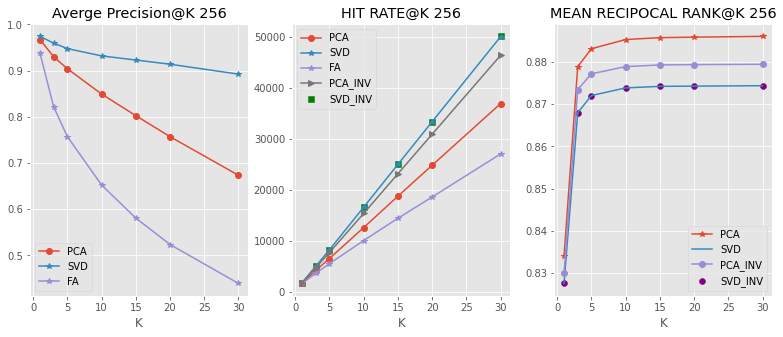

In [48]:
plt.figure(figsize = (18,5))
plt.subplot(1,4,1)
plt.plot(k,ap_pca_256, 'o-')
plt.plot(k,ap_svd_256, '-*')
plt.plot(k,ap_fa_256, '-*')
plt.title('Averge Precision@K 256')
plt.legend(['PCA','SVD','FA'])
plt.xlabel('K');

plt.subplot(1,4,2)
plt.plot(k,hit_pca_256, '-o')
plt.plot(k,hit_svd_256, '-*')
plt.plot(k,hit_fa_256, '-*')
plt.plot(k,hit_pca_256_inverse, '>-')
plt.scatter(k,hit_svd_256_inverse, marker = 's', color= 'green')
# plt.plot(k,hit_fa, '->')
plt.title('HIT RATE@K 256')
plt.legend(['PCA','SVD','FA','PCA_INV','SVD_INV'])
plt.xlabel('K');

plt.subplot(1,4,3)
# plt.subplot(1,2,1)
plt.plot(k,mrr_pca_256, '-*')
plt.plot(k,mrr_svd_256)
plt.plot(k,mrr_pca_256_inverse, 'o-')
plt.scatter(k,mrr_svd_256_inverse,color= 'purple')
plt.title('MEAN RECIPOCAL RANK@K 256')
plt.legend(['PCA','SVD','PCA_INV','SVD_INV'])
plt.xlabel('K');

In [ ]:
# num = 2
# print('RAW VECTORS:',list(searcher_raw.search(title_gpt_vectors[num])[0][0:10]))
# print('reduced VECTORS PCA:',list(searcher_pca.search(title_vectors_pca[num])[0][0:10]))
# print('reduced VECTORS SVD:',list(searcher_svd.search(title_vectors_svd[num])[0][0:10]))

### DIM 593


In [49]:
fa_593 = FactorAnalysis(max_iter= 25, n_components = 593 ).fit(embedding_vectors)
fa_593_reduced_content = fa_593.transform(embedding_vectors)
fa_593_reduced_title = fa_593.transform(title_gpt_vectors)

np.save('./fa_593_reduced_content.npy',fa_593_reduced_content)
np.save('./fa_593_reduced_title.npy',fa_593_reduced_title)

# fa_1007 = FactorAnalysis(max_iter= 25, n_components = 1007 ).fit(embedding_vectors)
# fa_1007_reduced_content = fa_1007.transform(embedding_vectors)
# fa_1007_reduced_title = fa_1007.transform(title_gpt_vectors)

# np.save('./svd_1007_reduced_content.npy',svd_1007_reduced_content)
# np.save('./svd_1007_reduced_title.npy',svd_1007_reduced_title)
     

In [50]:
# searcher_raw = scann.scann_ops_pybind.builder(embedding_vectors, 50, "dot_product").tree(
#     num_leaves=1500, num_leaves_to_search=100, training_sample_size=250000).score_ah(
#     2, anisotropic_quantization_threshold=0.2).reorder(100).build()

searcher_pca_593 = scann.scann_ops_pybind.builder(content_pca_593, 50, "dot_product").tree(
    num_leaves=1500, num_leaves_to_search=100, training_sample_size=250000).score_ah(
    2, anisotropic_quantization_threshold=0.2).reorder(100).build()

searcher_svd_593 = scann.scann_ops_pybind.builder(content_svd_593, 50, "dot_product").tree(
    num_leaves=1500, num_leaves_to_search=100, training_sample_size=250000).score_ah(
    2, anisotropic_quantization_threshold=0.2).reorder(100).build() 

searcher_pca_593_inverse = scann.scann_ops_pybind.builder(content_pca_593_inverse, 50, "dot_product").tree(
    num_leaves=1500, num_leaves_to_search=100, training_sample_size=250000).score_ah(
    2, anisotropic_quantization_threshold=0.2).reorder(100).build() 

searcher_svd_593_inverse = scann.scann_ops_pybind.builder(content_svd_593_inverse, 50, "dot_product").tree(
    num_leaves=1500, num_leaves_to_search=100, training_sample_size=250000).score_ah(
    2, anisotropic_quantization_threshold=0.2).reorder(100).build()     

# searcher_fa_593 = scann.scann_ops_pybind.builder(fa_593_reduced_content, 50, "dot_product").tree(
#     num_leaves=1500, num_leaves_to_search=100, training_sample_size=250000).score_ah(
#     2, anisotropic_quantization_threshold=0.2).reorder(100).build()       

In [51]:
# raw_idx = []
reduced_idx_pca_593 = []
reduced_idx_svd_593 = []
inverse_idx_pca_593 = []
inverse_idx_svd_593 = []
reduced_idx_fa_593 = []
for i in range(query_num):
    # raw_idx.append(searcher_raw.search(title_gpt_vectors[i])[0])
    reduced_idx_pca_593.append(searcher_pca_593.search(title_pca_593[i])[0])
    reduced_idx_svd_593.append(searcher_svd_593.search(title_svd_593[i])[0])
    inverse_idx_pca_593.append(searcher_pca_593_inverse.search(title_pca_593_inverse[i])[0])
    inverse_idx_svd_593.append(searcher_svd_593_inverse.search(title_svd_593_inverse[i])[0])
    # reduced_idx_fa_593.append(searcher_fa_593.search(fa_593_reduced_title[i])[0])

In [52]:
k = [1,3,5,10,15,20,30]
ap_pca_593, hit_pca_593, mrr_pca_593 = metrics_calculator(raw_idx,reduced_idx_pca_593, k )
ap_svd_593, hit_svd_593, mrr_svd_593 = metrics_calculator(raw_idx,reduced_idx_svd_593, k )
# ap_fa_593, hit_fa_593, mrr_fa_593 = metrics_calculator(raw_idx,reduced_idx_fa_593, k )

ap_pca_593_inverse, hit_pca_593_inverse, mrr_pca_593_inverse = metrics_calculator(raw_idx,inverse_idx_pca_593, k)
ap_svd_593_inverse, hit_svd_593_inverse, mrr_svd_593_inverse = metrics_calculator(raw_idx,inverse_idx_svd_593, k)

<ipython-input-18-bd2990ce089b>:37: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  elevated_rank = np.add(rank,1)


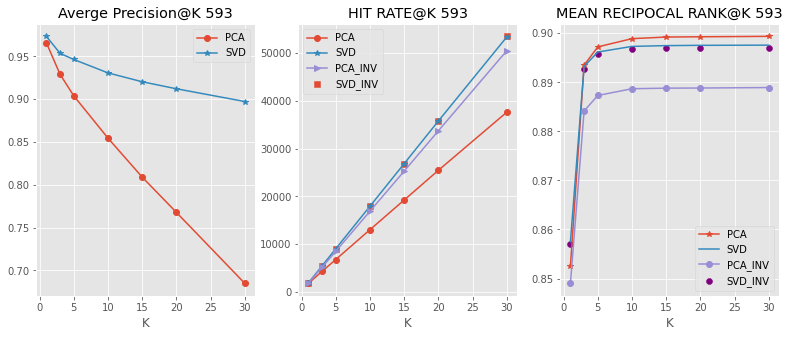

In [53]:
plt.figure(figsize = (18,5))
plt.subplot(1,4,1)
plt.plot(k,ap_pca_593, 'o-')
plt.plot(k,ap_svd_593, '-*')
# plt.plot(k,ap_fa_593, '-*')
plt.title('Averge Precision@K 593')
plt.legend(['PCA','SVD','FA'])
plt.xlabel('K');

plt.subplot(1,4,2)
plt.plot(k,hit_pca_593, '-o')
plt.plot(k,hit_svd_593, '-*')
# plt.plot(k,hit_fa_593, '-*')
plt.plot(k,hit_pca_593_inverse, '>-')
plt.scatter(k,hit_svd_593_inverse, marker = 's', alpha = 1)
# plt.plot(k,hit_fa, '->')
plt.title('HIT RATE@K 593')
plt.legend(['PCA','SVD','PCA_INV','SVD_INV'])
plt.xlabel('K');

plt.subplot(1,4,3)
# plt.subplot(1,2,1)
plt.plot(k,mrr_pca_593, '-*')
plt.plot(k,mrr_svd_593)
plt.plot(k,mrr_pca_593_inverse, 'o-')
plt.scatter(k,mrr_svd_593_inverse,color= 'purple')
plt.title('MEAN RECIPOCAL RANK@K 593')
plt.legend(['PCA','SVD','PCA_INV','SVD_INV'])
plt.xlabel('K');

## DIM 1007

In [54]:
searcher_pca_1007 = scann.scann_ops_pybind.builder(content_pca_1007 , 50, "dot_product").tree(
    num_leaves=1500, num_leaves_to_search=100, training_sample_size=250000).score_ah(
    2, anisotropic_quantization_threshold=0.2).reorder(100).build()

searcher_svd_1007  = scann.scann_ops_pybind.builder(content_svd_1007 , 50, "dot_product").tree(
    num_leaves=1500, num_leaves_to_search=100, training_sample_size=250000).score_ah(
    2, anisotropic_quantization_threshold=0.2).reorder(100).build() 

searcher_pca_1007_inverse = scann.scann_ops_pybind.builder(content_pca_1007_inverse, 50, "dot_product").tree(
    num_leaves=1500, num_leaves_to_search=100, training_sample_size=250000).score_ah(
    2, anisotropic_quantization_threshold=0.2).reorder(100).build() 

searcher_svd_1007_inverse = scann.scann_ops_pybind.builder(content_svd_1007_inverse, 50, "dot_product").tree(
    num_leaves=1500, num_leaves_to_search=100, training_sample_size=250000).score_ah(
    2, anisotropic_quantization_threshold=0.2).reorder(100).build()     

# searcher_fa_593 = scann.scann_ops_pybind.builder(fa_593_reduced_content, 50, "dot_product").tree(
#     num_leaves=1500, num_leaves_to_search=100, training_sample_size=250000).score_ah(
#     2, anisotropic_quantization_threshold=0.2).reorder(100).build()

In [55]:
# raw_idx = []
reduced_idx_pca_1007 = []
reduced_idx_svd_1007 = []
inverse_idx_pca_1007 = []
inverse_idx_svd_1007 = []
# reduced_idx_fa_1007 = []
for i in range(query_num):
    # raw_idx.append(searcher_raw.search(title_gpt_vectors[i])[0])
    reduced_idx_pca_1007.append(searcher_pca_1007.search(title_pca_1007[i])[0])
    reduced_idx_svd_1007.append(searcher_svd_1007.search(title_svd_1007[i])[0])
    inverse_idx_pca_1007.append(searcher_pca_1007_inverse.search(title_pca_1007_inverse[i])[0])
    inverse_idx_svd_1007.append(searcher_svd_1007_inverse.search(title_svd_1007_inverse[i])[0])
    # reduced_idx_fa_593.append(searcher_fa_593.search(fa_593_reduced_title[i])[0])

In [56]:
k = [1,3,5,10,15,20,30]
ap_pca_1007, hit_pca_1007, mrr_pca_1007 = metrics_calculator(raw_idx,reduced_idx_pca_1007, k )
ap_svd_1007, hit_svd_1007, mrr_svd_1007 = metrics_calculator(raw_idx,reduced_idx_svd_1007, k )
# ap_fa_593, hit_fa_593, mrr_fa_593 = metrics_calculator(raw_idx,reduced_idx_fa_593, k )

ap_pca_1007_inverse, hit_pca_1007_inverse, mrr_pca_1007_inverse = metrics_calculator(raw_idx,inverse_idx_pca_1007, k)
ap_svd_1007_inverse, hit_svd_1007_inverse, mrr_svd_1007_inverse = metrics_calculator(raw_idx,inverse_idx_svd_1007, k)

<ipython-input-18-bd2990ce089b>:37: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  elevated_rank = np.add(rank,1)


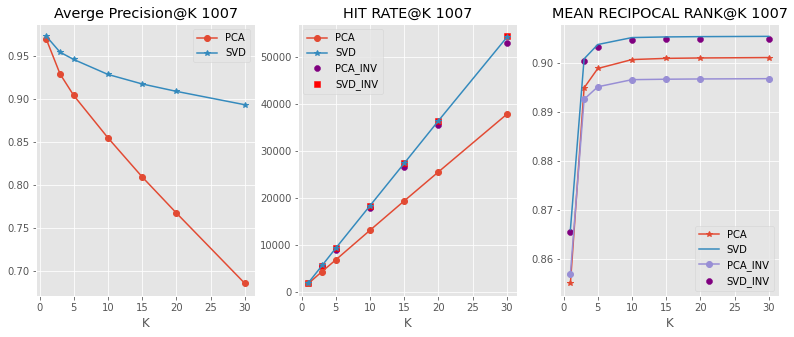

In [57]:
plt.figure(figsize = (18,5))
plt.subplot(1,4,1)
plt.plot(k,ap_pca_1007, 'o-')
plt.plot(k,ap_svd_1007, '-*')
# plt.plot(k,ap_fa_593, '-*')
plt.title('Averge Precision@K 1007')
plt.legend(['PCA','SVD','FA'])
plt.xlabel('K');

plt.subplot(1,4,2)
plt.plot(k,hit_pca_1007, '-o')
plt.plot(k,hit_svd_1007, '-*')
# plt.plot(k,hit_fa_1007, '-*')
plt.scatter(k,hit_pca_1007_inverse, color = 'purple')
plt.scatter(k,hit_svd_1007_inverse, color = 'red', marker = 's')
# plt.plot(k,hit_fa, '->')
plt.title('HIT RATE@K 1007')
plt.legend(['PCA','SVD','PCA_INV','SVD_INV'])
plt.xlabel('K');

plt.subplot(1,4,3)
# plt.subplot(1,2,1)
plt.plot(k,mrr_pca_1007, '-*')
plt.plot(k,mrr_svd_1007)
plt.plot(k,mrr_pca_1007_inverse, 'o-')
plt.scatter(k,mrr_svd_1007_inverse,color= 'purple')
plt.title('MEAN RECIPOCAL RANK@K 1007')
plt.legend(['PCA','SVD','PCA_INV','SVD_INV'])
plt.xlabel('K');

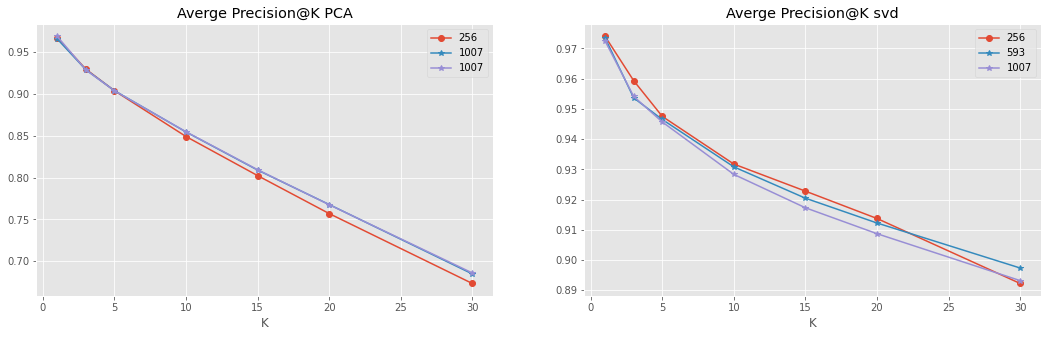

In [58]:
plt.figure(figsize = (18,5))
plt.subplot(1,2,1)
plt.plot(k,ap_pca_256, 'o-')
plt.plot(k,ap_pca_593, '-*')
plt.plot(k,ap_pca_1007, '-*')
plt.title('Averge Precision@K PCA')
plt.legend(['256','1007','1007'])
plt.xlabel('K');

plt.subplot(1,2,2)
plt.plot(k,ap_svd_256, 'o-')
plt.plot(k,ap_svd_593, '-*')
plt.plot(k,ap_svd_1007, '-*')
plt.title('Averge Precision@K svd')
plt.legend(['256','593','1007'])
plt.xlabel('K');


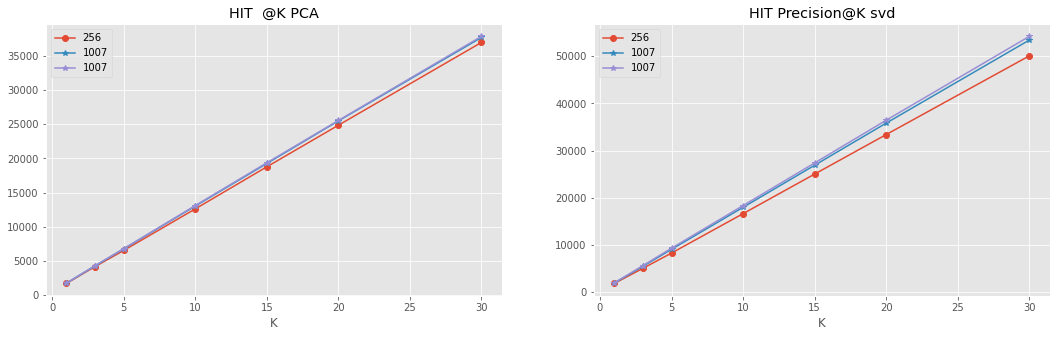

In [59]:
plt.figure(figsize = (18,5))
plt.subplot(1,2,1)
plt.plot(k,hit_pca_256, 'o-')
plt.plot(k,hit_pca_593, '-*')
plt.plot(k,hit_pca_1007, '-*')
plt.title('HIT  @K PCA')
plt.legend(['256','1007','1007'])
plt.xlabel('K');

plt.subplot(1,2,2)
plt.plot(k,hit_svd_256, 'o-')
plt.plot(k,hit_svd_593, '-*')
plt.plot(k,hit_svd_1007, '-*')
plt.title('HIT Precision@K svd')
plt.legend(['256','1007','1007'])
plt.xlabel('K');